Second file od Adult income analysis using ColumnTransformer for Data Preparation

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn import metrics
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.impute import SimpleImputer
from sklearn.neighbors import (KNeighborsClassifier, NeighborhoodComponentsAnalysis)
from sklearn.metrics import auc, confusion_matrix, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as SklearnLinearRegression, LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer

In [2]:
heading =['age', 'workclass', 'fnlwgt', 'education', 'education-num','marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country','income']
df = pd.read_csv("data/adult_data.txt", header=None, names = heading, na_values="?", skipinitialspace = True)
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Adding target column with 0/1 values <br>
0 when INCOME <=50K <br>
1 when INCOME >50

In [3]:
df['target'] = df['income']
df['target'] = np.where(df['income'].isin(['>50K']), 1, 0)

Correlation matrix to identify their relation with income.

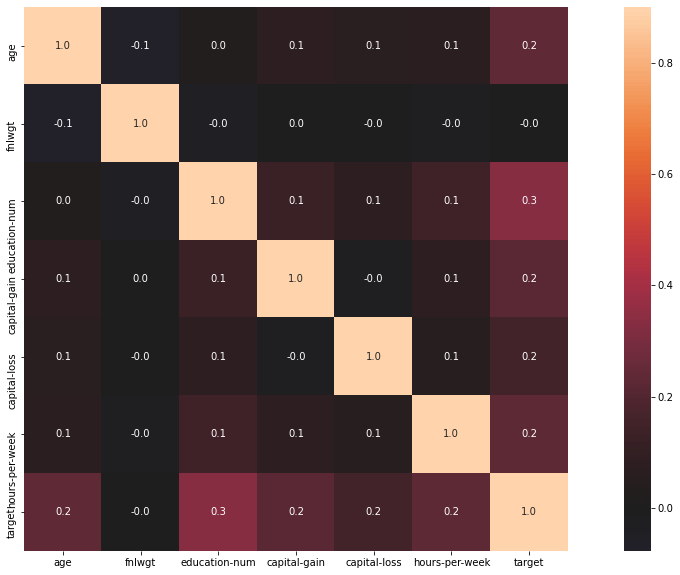

In [4]:
plt.subplots(figsize=(20, 10))
sns.heatmap(df.corr(), vmax=.9, square=True, annot=True, fmt='.1f', center=0)
plt.show()

I will drop <b>FNLWGT</b> beacuse has 0 corelation to target value

In [5]:
df = df.drop(['fnlwgt'], axis=1)

I will drop education, beacuse <b>Education</b> and <b>Education Number</b> are the same

In [6]:
df.drop(['education'], axis = 1, inplace = True)

In [7]:
df.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,target
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0


In [8]:
target = 'target'
num_features = ['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'education-num']
cat_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
features = df.columns.tolist()
features.remove(target)
X = df[features]
y = df[target]

In [69]:
def drawRocCurve(classifier, nameClassifier, X_test, y_test):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    # predict probabilities
    lr_probs = classifier.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('Random model: ROC AUC=%.3f' % (ns_auc))
    print(f'{nameClassifier}: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random model')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=nameClassifier)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    return lr_auc, lr_fpr, lr_tpr

In [10]:
def GridSearch(param, estimator, X=X, y=y):
    '''GridSearch function split the data for training and test sets; fit data 
    for a given model and choose the best paramethers using GridSearchCV from sklearn.
    At the end this function return score raport for the prediction'''
    # split into a training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    grid_rf = GridSearchCV(estimator, param, refit = True, verbose = 3, n_jobs=-1) 

    # fitting the model for grid search 
    grid_rf.fit(X_train, y_train) 

    # print best parameter after tuning 
    print(grid_rf.best_params_) 
    grid_rf_predictions = grid_rf.predict(X_test) 

    # print classification report 
    return classification_report(y_test, grid_rf_predictions)

In [11]:
 def ConfusionMatrix(classifier, X=X, y=y, confusionMatrix = True, plotConfusionMatrix = True):
        '''ConfusionMatrix function split data, fit data to model and give 
        a prediction for a given model and data. After that draw Confusion Matrix or 
        Plot Confusion Matrix to show the score'''

        #computing the confusion matrix with each row corresponding to the true class
        if(confusionMatrix):
            print(confusion_matrix(y_test, y_pred))

        #drawing Plot Confusion Matrix
        if(plotConfusionMatrix):
            plot_confusion_matrix(classifier, X_test, y_test)  
            plt.show() 

In [12]:
def featuresToOther(column, dataframe = df, percent=0.05, name_for_other="Other"):
    
    '''This function change features under given threshold to one group. 
    The group is called by name_for_other, default- Other'''
    
    frame = dataframe[column].value_counts().to_frame()
    values =  dataframe[column].value_counts().index.tolist()
    sum_of_count = 0
    for n in range(len(frame.index)): 
        sum_of_count += frame.iloc[n]
    threshold = sum_of_count.iloc[0]*percent
    list_values_to_change= []
    for i in range(len(frame.index)):
        num = frame.iloc[i, 0]
        if(num < threshold):
            list_values_to_change.append(values[i])
    dataframe[column].replace(list_values_to_change, name_for_other, inplace = True)

In [13]:
insignificant_values = ['workclass', 'occupation', 'race', 'native-country']
for value in insignificant_values:
    featuresToOther(column=value, dataframe=df, percent=0.04)

In [14]:
target = 'target'
num_features = ['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'education-num']
cat_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
features = df.columns.tolist()
features.remove(target)
X = df[features]
y = df[target]

In [15]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Other')),
    ('onehot', SklearnOneHotEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])

### Decision Tree Classifier

model score: 0.824


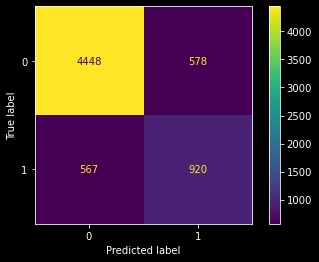

In [105]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',  DecisionTreeClassifier())])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

ConfusionMatrix(classifier=clf, confusionMatrix=False)

Random model: ROC AUC=0.500
Decision Tree Classifier: ROC AUC=0.773


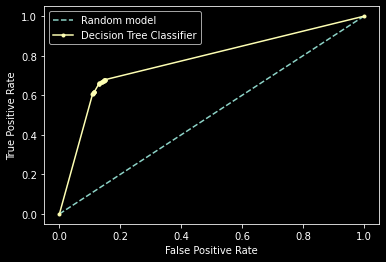

In [106]:
lr_auc_tree, lr_fpr_tree, lr_tpr_tree = drawRocCurve(clf, "Decision Tree Classifier", X_test, y_test)

### Random Forest Classifier

{'classifier__max_depth': 20, 'classifier__max_features': 10, 'classifier__n_estimators': 500}


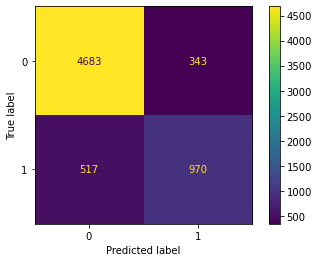

In [34]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',  RandomForestClassifier())])
param = {'classifier__max_depth': [2, 20],
         'classifier__n_estimators': [100, 500],
         'classifier__max_features': [10 , 20]}
gs = GridSearchCV(clf, param)
gs.fit(X_train, y_train)
best_params = gs.best_params_
print(best_params)
ConfusionMatrix(classifier=gs, confusionMatrix=False)

{'classifier__max_depth': 20, 'classifier__max_features': 10, 'classifier__min_samples_split': 30}


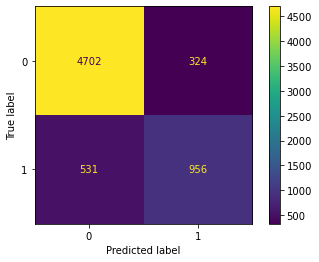

In [35]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',  RandomForestClassifier())])
param = {'classifier__max_depth': [20, 50],
         'classifier__max_features': [10, 30],
         'classifier__min_samples_split': [10, 30]}
gs = GridSearchCV(clf, param)
gs.fit(X_train, y_train)
best_params = gs.best_params_
print(best_params)
ConfusionMatrix(classifier=gs, confusionMatrix=False)

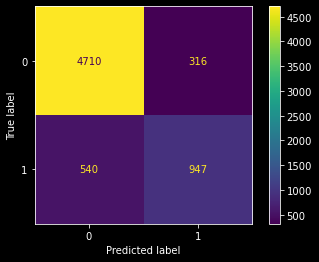

In [107]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',  RandomForestClassifier(max_depth =  20,max_features =  10,
                                                             min_samples_split =  30,
                                                             n_estimators =  500))])
clf.fit(X_train, y_train)
clf.predict(X_test)
ConfusionMatrix(classifier=clf, confusionMatrix=False)

Random model: ROC AUC=0.500
Random Forest Classifier: ROC AUC=0.916


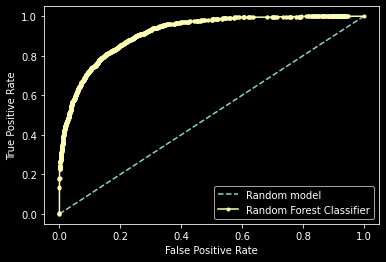

In [108]:
lr_auc_rf, lr_fpr_rf, lr_tpr_rf = drawRocCurve(clf, "Random Forest Classifier", X_test, y_test)

### Linear Regression Classifier

model score: 0.837


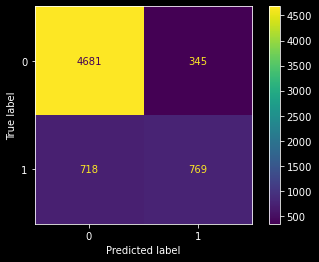

In [109]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',  RidgeClassifier())])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))
ConfusionMatrix(classifier=clf, confusionMatrix=False)

Random model: ROC AUC=0.500
Ridge Classifier: ROC AUC=0.724


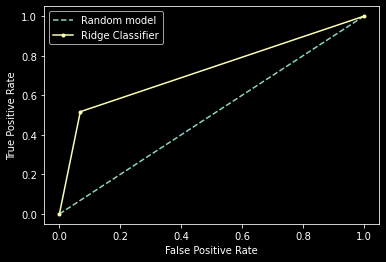

In [110]:
nameClassifier = "Ridge Classifier"
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = clf.predict(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('Random model: ROC AUC=%.3f' % (ns_auc))
print(f'{nameClassifier}: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random model')
plt.plot(lr_fpr, lr_tpr, marker='.', label=nameClassifier)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
lr_auc_rc, lr_fpr_rc, lr_tpr_rc = lr_auc, lr_fpr, lr_tpr

### Logistic Regerssion Classifier

/Users/ola/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


model score: 0.846


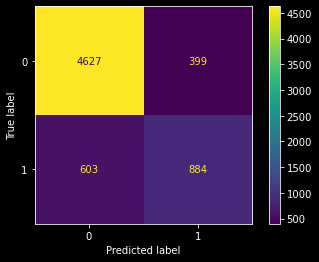

In [111]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',  LogisticRegression())])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))
ConfusionMatrix(classifier=clf, confusionMatrix=False)

Random model: ROC AUC=0.500
Logistic Regression: ROC AUC=0.899


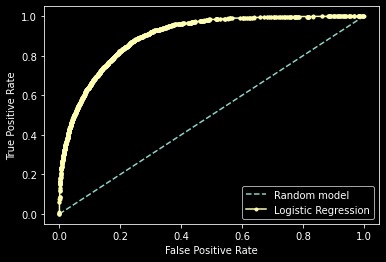

In [112]:
lr_auc_logr, lr_fpr_logr, lr_tpr_logr = drawRocCurve(clf, "Logistic Regression", X_test, y_test)

### k-Nearest Neighbours Classifier

{'knn__n_neighbors': 100, 'knn__p': 1, 'knn__weights': 'uniform'}


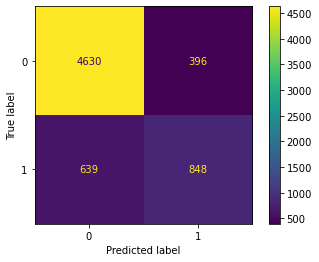

In [51]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('knn',  KNeighborsClassifier())])
param = {'knn__n_neighbors': [10, 100],
         'knn__weights': ['uniform', 'distance'],
         'knn__p': [1, 2]}
gs = GridSearchCV(clf, param)
gs.fit(X_train, y_train)
best_params = gs.best_params_
print(best_params)
ConfusionMatrix(classifier=gs, confusionMatrix=False)

{'knn__n_neighbors': 100, 'knn__p': 1, 'knn__weights': 'uniform'}


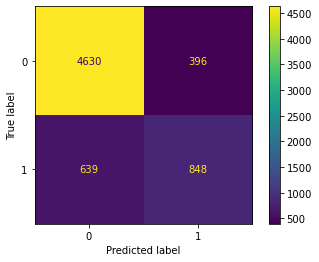

In [52]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('knn',  KNeighborsClassifier())])
param = {'knn__n_neighbors': [100, 500],
         'knn__weights': ['uniform'],
         'knn__p': [1]}
gs = GridSearchCV(clf, param)
gs.fit(X_train, y_train)
best_params = gs.best_params_
print(best_params)
ConfusionMatrix(classifier=gs, confusionMatrix=False)

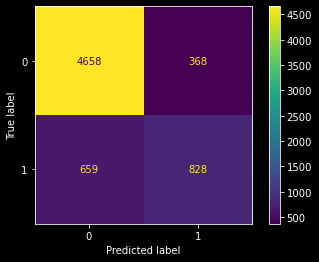

In [113]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('knn',  KNeighborsClassifier(n_neighbors=10, p=1, weights='uniform'))])
clf.fit(X_train, y_train)
clf.predict(X_test)
ConfusionMatrix(classifier=clf, confusionMatrix=False)

Random model: ROC AUC=0.500
K-Neighbors Classifier: ROC AUC=0.882


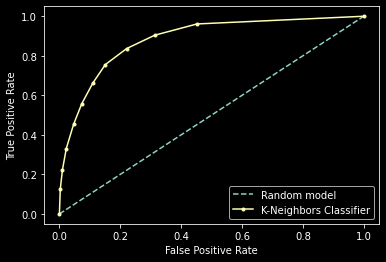

In [114]:
lr_auc_knn, lr_fpr_knn, lr_tpr_knn = drawRocCurve(clf, "K-Neighbors Classifier", X_test, y_test)

### Support Vector Classification

{'svc__C': 1, 'svc__kernel': 'poly'}


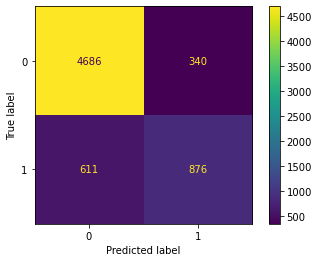

In [56]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('svc',  SVC())])
param = {'svc__C': [1, 10],
         'svc__kernel': ['linear', 'poly']}
gs = GridSearchCV(clf, param)
gs.fit(X_train, y_train)
best_params = gs.best_params_
print(best_params)
ConfusionMatrix(classifier=gs, confusionMatrix=False)

{'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


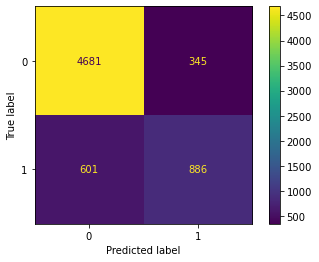

In [57]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('svc',  SVC())])
param = {'svc__kernel': ['poly', 'rbf'],
         'svc__gamma': ['scale', 'auto']
        }
gs = GridSearchCV(clf, param)
gs.fit(X_train, y_train)
best_params = gs.best_params_
print(best_params)
ConfusionMatrix(classifier=gs, confusionMatrix=False)

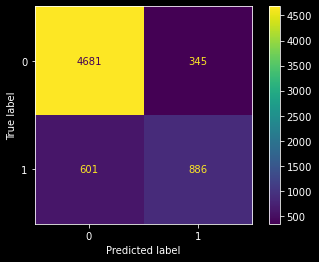

In [115]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('svc',  SVC(C = 1, kernel = "rbf", gamma = "scale", probability=True))])
clf.fit(X_train, y_train)
clf.predict(X_test)
ConfusionMatrix(classifier=clf, confusionMatrix=False)

Random model: ROC AUC=0.500
SVC: ROC AUC=0.894


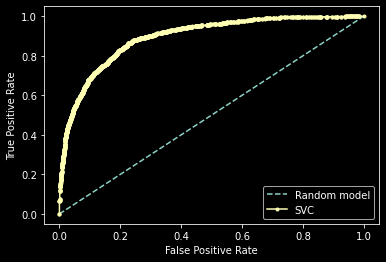

In [116]:
lr_auc_svm, lr_fpr_svm, lr_tpr_svm = drawRocCurve(clf, "SVC", X_test, y_test)

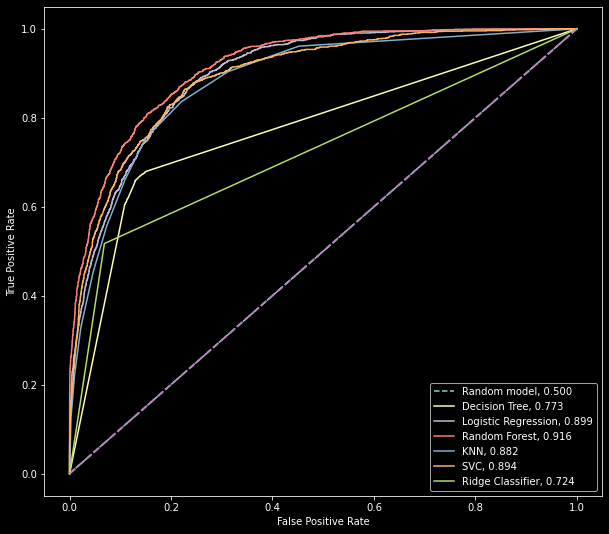

In [117]:
 # Determining the size of the drawing
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10,9))

#about Random model
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr_tree, lr_tpr_tree, label="Decision Tree, %.3f" % (lr_auc_tree))
plt.plot(lr_fpr_rf, lr_tpr_rf,  label="Random Forest, %.3f" % (lr_auc_rf))
plt.plot(lr_fpr_rc, lr_tpr_rc,  label="Ridge Classifier, %.3f" % (lr_auc_rc))
plt.plot(lr_fpr_logr, lr_tpr_logr, label="Logistic Regression, %.3f" % (lr_auc_logr))

plt.plot(lr_fpr_knn, lr_tpr_knn, label="K_Nearest , %.3f" % (lr_auc_knn))
plt.plot(lr_fpr_svm, lr_tpr_svm,  label="Support Vector Machine, %.3f" % (lr_auc_svm))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.savefig('images/ROC_ColumnTransformer.png')
# show the plot
plt.show()

### Best score has Random Forest